# Statistical Analysis: REJ Areas vs MassSave Participation

## Overview
This notebook performs a comprehensive statistical analysis to test the hypothesis:
**"REJ-flagged areas have a statistically significant lower participation rate in MassSave programs"**

We will analyze participation data across electric and gas utilities, comparing REJ and non-REJ census tracts across the State of Massachusetts.

## Analysis Outline
1. **Data Loading & Exploration** - Load and inspect the dataset
2. **Data Preparation** - Clean and prepare data for analysis
3. **Descriptive Statistics** - Summary statistics by REJ status
4. **Normality Testing** - Check assumptions for parametric tests
5. **Statistical Testing** - Perform t-tests and non-parametric alternatives
6. **Correlation Analysis** - Measure relationships between REJ status and participation
7. **Regression Analysis** - Build predictive models
8. **Visualization** - Create publication-ready figures
9. **Summary of Findings** - Interpret results and key insights

## Section 1: Import Required Libraries

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import (ttest_ind, mannwhitneyu, shapiro, levene, 
                         pearsonr, spearmanr, f_oneway)
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm
import warnings
warnings.filterwarnings('ignore')

# Set visualization style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 10

## Section 2: Load and Explore the Dataset

In [3]:
# Load the dataset
data = pd.read_csv('../data/rej_with_masssave_participation_table.csv')

# Display basic information about the dataset
print("Dataset Shape:", data.shape)
print("\n" + "="*80)
print("Column Names and Data Types:")
print("="*80)
print(data.dtypes)
print("\n" + "="*80)
print("First Few Rows:")
print("="*80)
data.head()

Dataset Shape: (1311, 25)

Column Names and Data Types:
OBJECTID                             int64
OBJECTID_1                         float64
GeoID                                int64
MPO                                 object
POPULATION                         float64
ZVHH_flag                          float64
REJ__des                           float64
REJ__flag_                          object
POP20_SQMI                         float64
MPO_short                          float64
AnalysisAr                         float64
Tract_Num                          float64
pct_lep_fl                         float64
pct_nonwhi                         float64
median_inc                         float64
Senior_fla                         float64
Disabili_f                         float64
GEOID_Text                           int64
Shape_Leng                         float64
Shape_Length                       float64
Shape_Area                         float64
town                                objec

,OBJECTID,OBJECTID_1,GeoID,MPO,POPULATION,ZVHH_flag,REJ__des,REJ__flag_,POP20_SQMI,MPO_short,...,Senior_fla,Disabili_f,GEOID_Text,Shape_Leng,Shape_Length,Shape_Area,town,electric_participation_rate_avg,gas_participation_rate_avg,block_group_count
0,1,1.0,25005613901,Southeastern Massachusetts,2934.0,0.0,0.0,No,5969.4,13.0,...,0.0,0.0,25005613901,0.062104,0.062104,0.000138,Taunton,0.000000,5.932000,10
1,2,2.0,25009260402,Merrimack Valley,6919.0,0.0,0.0,No,1027.9,7.0,...,0.0,0.0,25009260402,0.197241,0.197241,0.001941,Haverhill,27.240000,22.440000,15
2,3,3.0,25009210500,Boston Region,6964.0,0.0,0.0,No,3734.4,2.0,...,0.0,0.0,25009210500,0.118203,0.118203,0.000527,Peabody,0.000000,18.534000,20
3,4,4.0,25017322300,Boston Region,6254.0,0.0,3.0,Yes,3172.2,2.0,...,1.0,1.0,25017322300,0.113177,0.113177,0.000560,Hudson,0.000000,19.589333,15
4,5,5.0,25001011600,Cape Cod,2982.0,0.0,1.0,Yes,1146.2,3.0,...,0.0,0.0,25001011600,0.150223,0.150223,0.000684,Dennis,20.698667,12.018667,15


In [4]:
# Check for missing values in key columns
print("\n" + "="*80)
print("Missing Values in Key Columns:")
print("="*80)
key_cols = ['REJ__flag_', 'electric_participation_rate_avg', 'gas_participation_rate_avg', 
            'ZVHH_flag', 'Senior_fla', 'Disabili_f', 'POPULATION']
missing_data = data[key_cols].isnull().sum()
print(missing_data)
print(f"\nTotal Missing Values: {missing_data.sum()}")

# Convert REJ flag to string labels for clarity
print("\n" + "="*80)
print("REJ Status Distribution:")
print("="*80)
rej_counts = data['REJ__flag_'].value_counts(dropna=False)
print(rej_counts)

# Summary statistics
print("\n" + "="*80)
print("Summary Statistics for Participation Rates:")
print("="*80)
print(data[['electric_participation_rate_avg', 'gas_participation_rate_avg']].describe())


Missing Values in Key Columns:
REJ__flag_                         0
electric_participation_rate_avg    0
gas_participation_rate_avg         0
ZVHH_flag                          0
Senior_fla                         0
Disabili_f                         0
POPULATION                         0
dtype: int64

Total Missing Values: 0

REJ Status Distribution:
REJ__flag_
Yes    858
No     453
Name: count, dtype: int64

Summary Statistics for Participation Rates:
       electric_participation_rate_avg  gas_participation_rate_avg
count                      1311.000000                 1311.000000
mean                         23.637472                   15.415586
std                          11.847586                    9.478633
min                           0.000000                    0.000000
25%                          18.522800                    8.480667
50%                          26.248000                   15.277333
75%                          31.981800                   22.387000
max  

## Section 3: Data Preparation

We'll clean the data and prepare it for analysis by:
- Converting REJ flag to a binary numeric variable (1 = REJ, 0 = Non-REJ)
- Removing rows with missing values in critical columns
- Creating descriptive labels

In [5]:
# Create a clean dataset for analysis
data_clean = data.copy()

# Convert REJ flag to numeric (1 for Yes/REJ, 0 for No/Non-REJ)
# The original column contains 'Yes' and 'No' strings
data_clean['REJ_flag_numeric'] = (data_clean['REJ__flag_'] == 'Yes').astype(int)

# Remove rows with missing values in key analysis columns
analysis_cols = ['REJ_flag_numeric', 'electric_participation_rate_avg', 
                 'gas_participation_rate_avg', 'POPULATION']
data_clean = data_clean.dropna(subset=analysis_cols)

print(f"Original dataset size: {len(data)}")
print(f"Cleaned dataset size: {len(data_clean)}")
print(f"Rows removed: {len(data) - len(data_clean)}")

print("\n" + "="*80)
print("REJ Status Distribution in Cleaned Data:")
print("="*80)
print(f"REJ Areas (Yes): {(data_clean['REJ_flag_numeric'] == 1).sum()}")
print(f"Non-REJ Areas (No): {(data_clean['REJ_flag_numeric'] == 0).sum()}")

Original dataset size: 1311
Cleaned dataset size: 1311
Rows removed: 0

REJ Status Distribution in Cleaned Data:
REJ Areas (Yes): 858
Non-REJ Areas (No): 453


## Section 4: Descriptive Statistics

Compare mean, median, and standard deviation of participation rates between REJ and non-REJ areas.

In [6]:
# Separate REJ and non-REJ groups
rej_group = data_clean[data_clean['REJ_flag_numeric'] == 1]
non_rej_group = data_clean[data_clean['REJ_flag_numeric'] == 0]

# Summary statistics for electric participation rate
print("="*80)
print("ELECTRIC PARTICIPATION RATE")
print("="*80)
print("\nREJ Areas:")
print(rej_group['electric_participation_rate_avg'].describe())
print("\nNon-REJ Areas:")
print(non_rej_group['electric_participation_rate_avg'].describe())

# Summary statistics for gas participation rate
print("\n" + "="*80)
print("GAS PARTICIPATION RATE")
print("="*80)
print("\nREJ Areas:")
print(rej_group['gas_participation_rate_avg'].describe())
print("\nNon-REJ Areas:")
print(non_rej_group['gas_participation_rate_avg'].describe())

# Create comparison table
print("\n" + "="*80)
print("COMPARISON TABLE: REJ vs Non-REJ")
print("="*80)
comparison = pd.DataFrame({
    'Electric (REJ)': [
        rej_group['electric_participation_rate_avg'].mean(),
        rej_group['electric_participation_rate_avg'].median(),
        rej_group['electric_participation_rate_avg'].std()
    ],
    'Electric (Non-REJ)': [
        non_rej_group['electric_participation_rate_avg'].mean(),
        non_rej_group['electric_participation_rate_avg'].median(),
        non_rej_group['electric_participation_rate_avg'].std()
    ],
    'Gas (REJ)': [
        rej_group['gas_participation_rate_avg'].mean(),
        rej_group['gas_participation_rate_avg'].median(),
        rej_group['gas_participation_rate_avg'].std()
    ],
    'Gas (Non-REJ)': [
        non_rej_group['gas_participation_rate_avg'].mean(),
        non_rej_group['gas_participation_rate_avg'].median(),
        non_rej_group['gas_participation_rate_avg'].std()
    ]
}, index=['Mean', 'Median', 'Std Dev'])

print(comparison.round(2))

ELECTRIC PARTICIPATION RATE

REJ Areas:
count    858.000000
mean      23.177249
std       11.242659
min        0.000000
25%       17.710000
50%       24.664000
75%       31.207333
max       72.000000
Name: electric_participation_rate_avg, dtype: float64

Non-REJ Areas:
count    453.000000
mean      24.509151
std       12.883931
min        0.000000
25%       21.292000
50%       28.868000
75%       33.164000
max       46.205333
Name: electric_participation_rate_avg, dtype: float64

GAS PARTICIPATION RATE

REJ Areas:
count    858.000000
mean      14.395946
std        9.031407
min        0.000000
25%        7.798000
50%       14.183000
75%       20.504000
max       50.468000
Name: gas_participation_rate_avg, dtype: float64

Non-REJ Areas:
count    453.000000
mean      17.346824
std       10.001368
min        0.000000
25%        9.882667
50%       18.534000
75%       25.213333
max       80.000000
Name: gas_participation_rate_avg, dtype: float64

COMPARISON TABLE: REJ vs Non-REJ
         Ele

## Section 5: Check Normality Assumptions

Before performing parametric tests (t-tests), we must check if our data is normally distributed using the Shapiro-Wilk test.

In [7]:
# Test for normality using Shapiro-Wilk test
print("="*80)
print("SHAPIRO-WILK NORMALITY TEST")
print("="*80)
print("\nNull Hypothesis: Data is normally distributed")
print("If p-value < 0.05, reject null hypothesis (data is NOT normally distributed)\n")

# Electric participation rates
print("ELECTRIC PARTICIPATION RATE")
print("-" * 80)
stat_rej, p_rej = shapiro(rej_group['electric_participation_rate_avg'])
stat_non_rej, p_non_rej = shapiro(non_rej_group['electric_participation_rate_avg'])
print(f"REJ Areas:     Statistic = {stat_rej:.4f}, p-value = {p_rej:.4f}", 
      "✓ Normal" if p_rej > 0.05 else "✗ NOT Normal")
print(f"Non-REJ Areas: Statistic = {stat_non_rej:.4f}, p-value = {p_non_rej:.4f}",
      "✓ Normal" if p_non_rej > 0.05 else "✗ NOT Normal")

# Gas participation rates
print("\nGAS PARTICIPATION RATE")
print("-" * 80)
stat_rej_gas, p_rej_gas = shapiro(rej_group['gas_participation_rate_avg'])
stat_non_rej_gas, p_non_rej_gas = shapiro(non_rej_group['gas_participation_rate_avg'])
print(f"REJ Areas:     Statistic = {stat_rej_gas:.4f}, p-value = {p_rej_gas:.4f}",
      "✓ Normal" if p_rej_gas > 0.05 else "✗ NOT Normal")
print(f"Non-REJ Areas: Statistic = {stat_non_rej_gas:.4f}, p-value = {p_non_rej_gas:.4f}",
      "✓ Normal" if p_non_rej_gas > 0.05 else "✗ NOT Normal")

# Test for homogeneity of variance using Levene's test
print("\n" + "="*80)
print("LEVENE'S TEST FOR HOMOGENEITY OF VARIANCE")
print("="*80)
print("\nNull Hypothesis: Variances are equal between groups")
print("If p-value < 0.05, reject null hypothesis (variances are NOT equal)\n")

stat_lev_elec, p_lev_elec = levene(rej_group['electric_participation_rate_avg'], 
                                     non_rej_group['electric_participation_rate_avg'])
stat_lev_gas, p_lev_gas = levene(rej_group['gas_participation_rate_avg'],
                                  non_rej_group['gas_participation_rate_avg'])

print(f"Electric: Statistic = {stat_lev_elec:.4f}, p-value = {p_lev_elec:.4f}",
      "✓ Equal Variances" if p_lev_elec > 0.05 else "✗ Unequal Variances")
print(f"Gas:      Statistic = {stat_lev_gas:.4f}, p-value = {p_lev_gas:.4f}",
      "✓ Equal Variances" if p_lev_gas > 0.05 else "✗ Unequal Variances")

SHAPIRO-WILK NORMALITY TEST

Null Hypothesis: Data is normally distributed
If p-value < 0.05, reject null hypothesis (data is NOT normally distributed)

ELECTRIC PARTICIPATION RATE
--------------------------------------------------------------------------------
REJ Areas:     Statistic = 0.9466, p-value = 0.0000 ✗ NOT Normal
Non-REJ Areas: Statistic = 0.8218, p-value = 0.0000 ✗ NOT Normal

GAS PARTICIPATION RATE
--------------------------------------------------------------------------------
REJ Areas:     Statistic = 0.9754, p-value = 0.0000 ✗ NOT Normal
Non-REJ Areas: Statistic = 0.9477, p-value = 0.0000 ✗ NOT Normal

LEVENE'S TEST FOR HOMOGENEITY OF VARIANCE

Null Hypothesis: Variances are equal between groups
If p-value < 0.05, reject null hypothesis (variances are NOT equal)

Electric: Statistic = 2.0381, p-value = 0.1536 ✓ Equal Variances
Gas:      Statistic = 8.0188, p-value = 0.0047 ✗ Unequal Variances


## Section 6: Statistical Testing

### 6.1 Independent Samples T-Test
We perform an independent samples t-test to compare participation rates between REJ and non-REJ areas.
This tests whether there is a statistically significant difference between group means.

In [8]:
# Perform t-tests
print("="*80)
print("INDEPENDENT SAMPLES T-TEST")
print("="*80)
print("\nNull Hypothesis (H0): Mean participation rates are equal between REJ and non-REJ")
print("Alternative Hypothesis (H1): Mean participation rates differ between groups")
print("Significance level (α): 0.05\n")

# T-test for electric participation rates
t_stat_elec, p_value_elec = ttest_ind(
    rej_group['electric_participation_rate_avg'], 
    non_rej_group['electric_participation_rate_avg'],
    nan_policy='omit'
)

# T-test for gas participation rates
t_stat_gas, p_value_gas = ttest_ind(
    rej_group['gas_participation_rate_avg'],
    non_rej_group['gas_participation_rate_avg'],
    nan_policy='omit'
)

# Calculate effect size (Cohen's d)
def cohens_d(group1, group2):
    n1, n2 = len(group1), len(group2)
    var1, var2 = group1.var(), group2.var()
    pooled_std = np.sqrt(((n1-1)*var1 + (n2-1)*var2) / (n1+n2-2))
    return (group1.mean() - group2.mean()) / pooled_std

d_elec = cohens_d(rej_group['electric_participation_rate_avg'], 
                   non_rej_group['electric_participation_rate_avg'])
d_gas = cohens_d(rej_group['gas_participation_rate_avg'],
                 non_rej_group['gas_participation_rate_avg'])

print("ELECTRIC PARTICIPATION RATE")
print("-" * 80)
print(f"REJ Mean:     {rej_group['electric_participation_rate_avg'].mean():.2f}%")
print(f"Non-REJ Mean: {non_rej_group['electric_participation_rate_avg'].mean():.2f}%")
print(f"Difference:   {rej_group['electric_participation_rate_avg'].mean() - non_rej_group['electric_participation_rate_avg'].mean():.2f}%")
print(f"t-statistic:  {t_stat_elec:.4f}")
print(f"p-value:      {p_value_elec:.6f}")
print(f"Cohen's d:    {d_elec:.4f}")
if p_value_elec < 0.05:
    print("✓ STATISTICALLY SIGNIFICANT (p < 0.05)")
else:
    print("✗ NOT statistically significant (p >= 0.05)")

print("\nGAS PARTICIPATION RATE")
print("-" * 80)
print(f"REJ Mean:     {rej_group['gas_participation_rate_avg'].mean():.2f}%")
print(f"Non-REJ Mean: {non_rej_group['gas_participation_rate_avg'].mean():.2f}%")
print(f"Difference:   {rej_group['gas_participation_rate_avg'].mean() - non_rej_group['gas_participation_rate_avg'].mean():.2f}%")
print(f"t-statistic:  {t_stat_gas:.4f}")
print(f"p-value:      {p_value_gas:.6f}")
print(f"Cohen's d:    {d_gas:.4f}")
if p_value_gas < 0.05:
    print("✓ STATISTICALLY SIGNIFICANT (p < 0.05)")
else:
    print("✗ NOT statistically significant (p >= 0.05)")

INDEPENDENT SAMPLES T-TEST

Null Hypothesis (H0): Mean participation rates are equal between REJ and non-REJ
Alternative Hypothesis (H1): Mean participation rates differ between groups
Significance level (α): 0.05

ELECTRIC PARTICIPATION RATE
--------------------------------------------------------------------------------
REJ Mean:     23.18%
Non-REJ Mean: 24.51%
Difference:   -1.33%
t-statistic:  -1.9377
p-value:      0.052873
Cohen's d:    -0.1125
✗ NOT statistically significant (p >= 0.05)

GAS PARTICIPATION RATE
--------------------------------------------------------------------------------
REJ Mean:     14.40%
Non-REJ Mean: 17.35%
Difference:   -2.95%
t-statistic:  -5.4181
p-value:      0.000000
Cohen's d:    -0.3147
✓ STATISTICALLY SIGNIFICANT (p < 0.05)


### 6.2 Mann-Whitney U Test (Non-Parametric Alternative)
Since some of our data may not be normally distributed, we also perform the Mann-Whitney U test,
which doesn't assume normality and tests whether distributions differ between groups.

In [9]:
# Perform Mann-Whitney U test
u_stat_elec, p_value_mw_elec = mannwhitneyu(
    rej_group['electric_participation_rate_avg'],
    non_rej_group['electric_participation_rate_avg'],
    alternative='two-sided'
)

u_stat_gas, p_value_mw_gas = mannwhitneyu(
    rej_group['gas_participation_rate_avg'],
    non_rej_group['gas_participation_rate_avg'],
    alternative='two-sided'
)

print("\n" + "="*80)
print("MANN-WHITNEY U TEST (Non-Parametric)")
print("="*80)
print("\nElectric Participation Rate:")
print(f"  U-statistic: {u_stat_elec:.4f}")
print(f"  p-value:     {p_value_mw_elec:.6f}", 
      "✓ SIGNIFICANT" if p_value_mw_elec < 0.05 else "✗ Not significant")

print("\nGas Participation Rate:")
print(f"  U-statistic: {u_stat_gas:.4f}")
print(f"  p-value:     {p_value_mw_gas:.6f}",
      "✓ SIGNIFICANT" if p_value_mw_gas < 0.05 else "✗ Not significant")


MANN-WHITNEY U TEST (Non-Parametric)

Electric Participation Rate:
  U-statistic: 164495.5000
  p-value:     0.000005 ✓ SIGNIFICANT

Gas Participation Rate:
  U-statistic: 157729.5000
  p-value:     0.000000 ✓ SIGNIFICANT


## Section 7: Correlation Analysis

Measure the strength and direction of the relationship between REJ status and participation rates
using both Pearson (parametric) and Spearman (non-parametric) correlations.

In [10]:
# Pearson Correlation
pearson_r_elec, p_pear_elec = pearsonr(data_clean['REJ_flag_numeric'], 
                                        data_clean['electric_participation_rate_avg'])
pearson_r_gas, p_pear_gas = pearsonr(data_clean['REJ_flag_numeric'],
                                      data_clean['gas_participation_rate_avg'])

# Spearman Correlation
spearman_r_elec, p_spear_elec = spearmanr(data_clean['REJ_flag_numeric'],
                                           data_clean['electric_participation_rate_avg'])
spearman_r_gas, p_spear_gas = spearmanr(data_clean['REJ_flag_numeric'],
                                         data_clean['gas_participation_rate_avg'])

print("="*80)
print("CORRELATION ANALYSIS")
print("="*80)
print("\nInterpretation: Negative correlation indicates lower participation in REJ areas")
print("Correlation range: -1.0 to +1.0 (stronger at extremes)")
print("p-value < 0.05 indicates statistically significant correlation\n")

print("PEARSON CORRELATION (Parametric)")
print("-" * 80)
print(f"Electric: r = {pearson_r_elec:.4f}, p-value = {p_pear_elec:.6f}",
      "✓ SIGNIFICANT" if p_pear_elec < 0.05 else "✗ Not significant")
print(f"Gas:      r = {pearson_r_gas:.4f}, p-value = {p_pear_gas:.6f}",
      "✓ SIGNIFICANT" if p_pear_gas < 0.05 else "✗ Not significant")

print("\nSPEARMAN CORRELATION (Non-Parametric)")
print("-" * 80)
print(f"Electric: ρ = {spearman_r_elec:.4f}, p-value = {p_spear_elec:.6f}",
      "✓ SIGNIFICANT" if p_spear_elec < 0.05 else "✗ Not significant")
print(f"Gas:      ρ = {spearman_r_gas:.4f}, p-value = {p_spear_gas:.6f}",
      "✓ SIGNIFICANT" if p_spear_gas < 0.05 else "✗ Not significant")

CORRELATION ANALYSIS

Interpretation: Negative correlation indicates lower participation in REJ areas
Correlation range: -1.0 to +1.0 (stronger at extremes)
p-value < 0.05 indicates statistically significant correlation

PEARSON CORRELATION (Parametric)
--------------------------------------------------------------------------------
Electric: r = -0.0535, p-value = 0.052873 ✗ Not significant
Gas:      r = -0.1481, p-value = 0.000000 ✓ SIGNIFICANT

SPEARMAN CORRELATION (Non-Parametric)
--------------------------------------------------------------------------------
Electric: ρ = -0.1266, p-value = 0.000004 ✓ SIGNIFICANT
Gas:      ρ = -0.1552, p-value = 0.000000 ✓ SIGNIFICANT


## Section 8: Regression Analysis

Build simple linear regression models to predict participation rates based on REJ status.
This allows us to quantify the effect of REJ status on participation rates.

In [11]:
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm

# Create a formula-ready dataset
reg_data = data_clean.copy()
reg_data['REJ_status'] = reg_data['REJ_flag_numeric'].map({0: 'Non-REJ', 1: 'REJ'})

# Model 1: Simple linear regression for electric participation
model_elec = ols('electric_participation_rate_avg ~ C(REJ_status)', data=reg_data).fit()

# Model 2: Simple linear regression for gas participation
model_gas = ols('gas_participation_rate_avg ~ C(REJ_status)', data=reg_data).fit()

print("="*80)
print("LINEAR REGRESSION ANALYSIS")
print("="*80)

print("\nMODEL 1: ELECTRIC PARTICIPATION RATE ~ REJ STATUS")
print("-" * 80)
print(model_elec.summary())

print("\nMODEL 2: GAS PARTICIPATION RATE ~ REJ STATUS")
print("-" * 80)
print(model_gas.summary())

LINEAR REGRESSION ANALYSIS

MODEL 1: ELECTRIC PARTICIPATION RATE ~ REJ STATUS
--------------------------------------------------------------------------------
                                   OLS Regression Results                                  
Dep. Variable:     electric_participation_rate_avg   R-squared:                       0.003
Model:                                         OLS   Adj. R-squared:                  0.002
Method:                              Least Squares   F-statistic:                     3.755
Date:                             Fri, 19 Dec 2025   Prob (F-statistic):             0.0529
Time:                                     16:52:54   Log-Likelihood:                -5098.8
No. Observations:                             1311   AIC:                         1.020e+04
Df Residuals:                                 1309   BIC:                         1.021e+04
Df Model:                                        1                                         
Covariance Ty

## Section 9: Visualization

Create publication-quality visualizations to illustrate the findings.

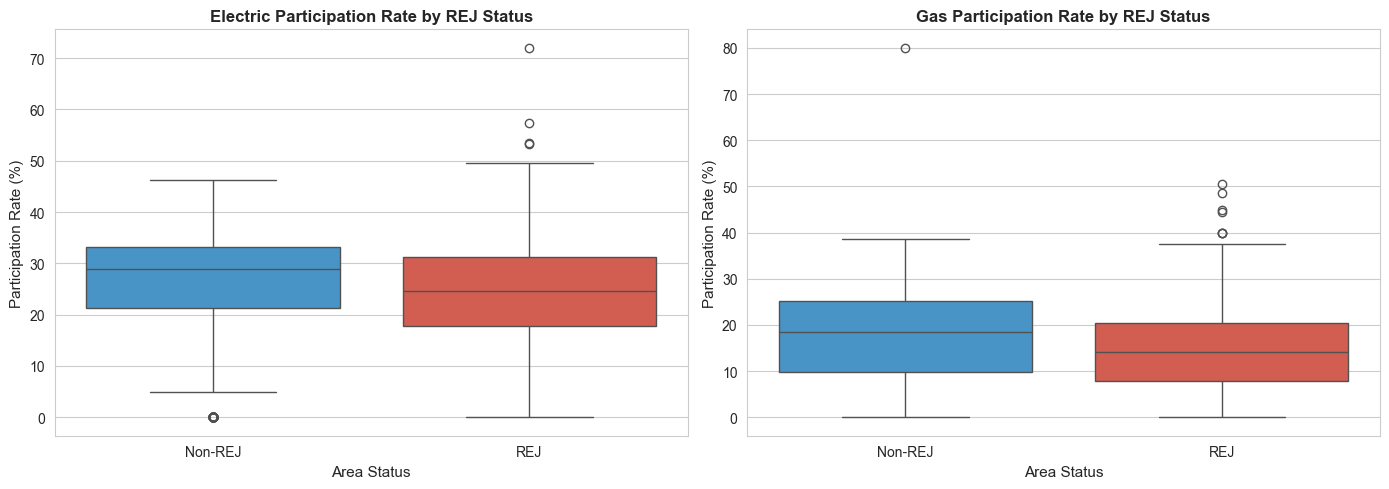

✓ Boxplots saved to ../visualizations/participation_boxplots.png


In [12]:
### 9.1 Box Plots: Distribution Comparison
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Prepare data for plotting
plot_data = data_clean.copy()
plot_data['REJ_Status'] = plot_data['REJ_flag_numeric'].map({0: 'Non-REJ', 1: 'REJ'})

# Electric participation boxplot
sns.boxplot(data=plot_data, x='REJ_Status', y='electric_participation_rate_avg', ax=axes[0],
            palette=['#3498db', '#e74c3c'])
axes[0].set_title('Electric Participation Rate by REJ Status', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Participation Rate (%)', fontsize=11)
axes[0].set_xlabel('Area Status', fontsize=11)

# Gas participation boxplot
sns.boxplot(data=plot_data, x='REJ_Status', y='gas_participation_rate_avg', ax=axes[1],
            palette=['#3498db', '#e74c3c'])
axes[1].set_title('Gas Participation Rate by REJ Status', fontsize=12, fontweight='bold')
axes[1].set_ylabel('Participation Rate (%)', fontsize=11)
axes[1].set_xlabel('Area Status', fontsize=11)

plt.tight_layout()
plt.savefig('../visualizations/participation_boxplots.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Boxplots saved to ../visualizations/participation_boxplots.png")

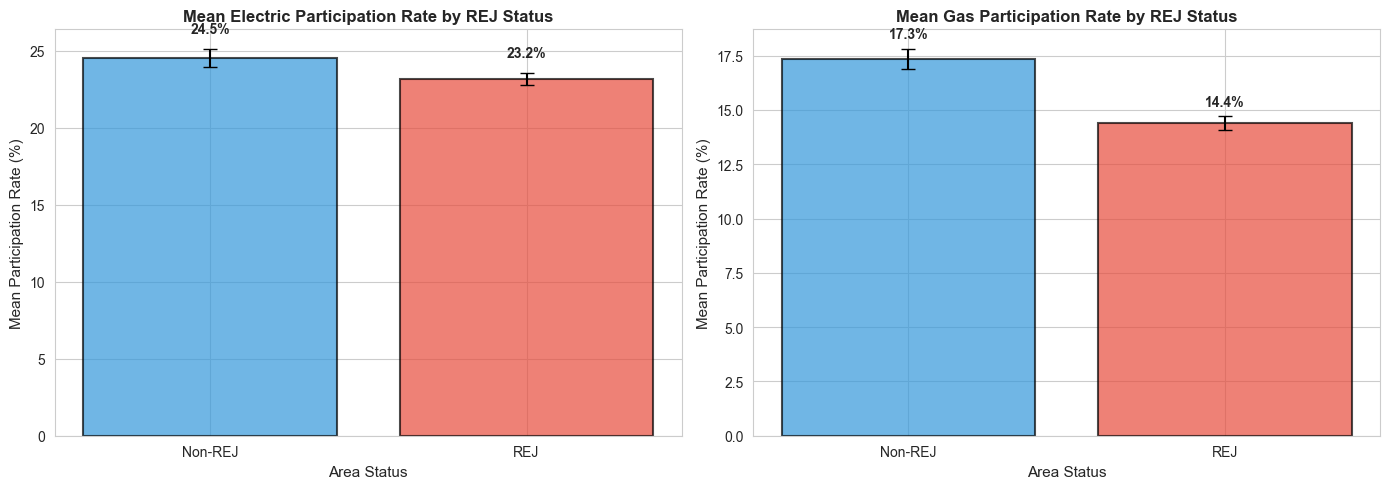

✓ Bar charts saved to ../visualizations/participation_bar_charts.png


In [13]:
### 9.2 Bar Charts: Mean Participation Comparison
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Calculate means
means_elec = plot_data.groupby('REJ_Status')['electric_participation_rate_avg'].mean()
means_gas = plot_data.groupby('REJ_Status')['gas_participation_rate_avg'].mean()

# Calculate standard errors
se_elec = plot_data.groupby('REJ_Status')['electric_participation_rate_avg'].sem()
se_gas = plot_data.groupby('REJ_Status')['gas_participation_rate_avg'].sem()

# Electric participation bar chart
axes[0].bar(means_elec.index, means_elec.values, color=['#3498db', '#e74c3c'], 
            yerr=se_elec.values, capsize=5, alpha=0.7, edgecolor='black', linewidth=1.5)
axes[0].set_title('Mean Electric Participation Rate by REJ Status', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Mean Participation Rate (%)', fontsize=11)
axes[0].set_xlabel('Area Status', fontsize=11)
for i, (idx, val) in enumerate(means_elec.items()):
    axes[0].text(i, val + se_elec[idx] + 1, f'{val:.1f}%', ha='center', fontweight='bold')

# Gas participation bar chart
axes[1].bar(means_gas.index, means_gas.values, color=['#3498db', '#e74c3c'],
            yerr=se_gas.values, capsize=5, alpha=0.7, edgecolor='black', linewidth=1.5)
axes[1].set_title('Mean Gas Participation Rate by REJ Status', fontsize=12, fontweight='bold')
axes[1].set_ylabel('Mean Participation Rate (%)', fontsize=11)
axes[1].set_xlabel('Area Status', fontsize=11)
for i, (idx, val) in enumerate(means_gas.items()):
    axes[1].text(i, val + se_gas[idx] + 0.5, f'{val:.1f}%', ha='center', fontweight='bold')

plt.tight_layout()
plt.savefig('../visualizations/participation_bar_charts.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Bar charts saved to ../visualizations/participation_bar_charts.png")

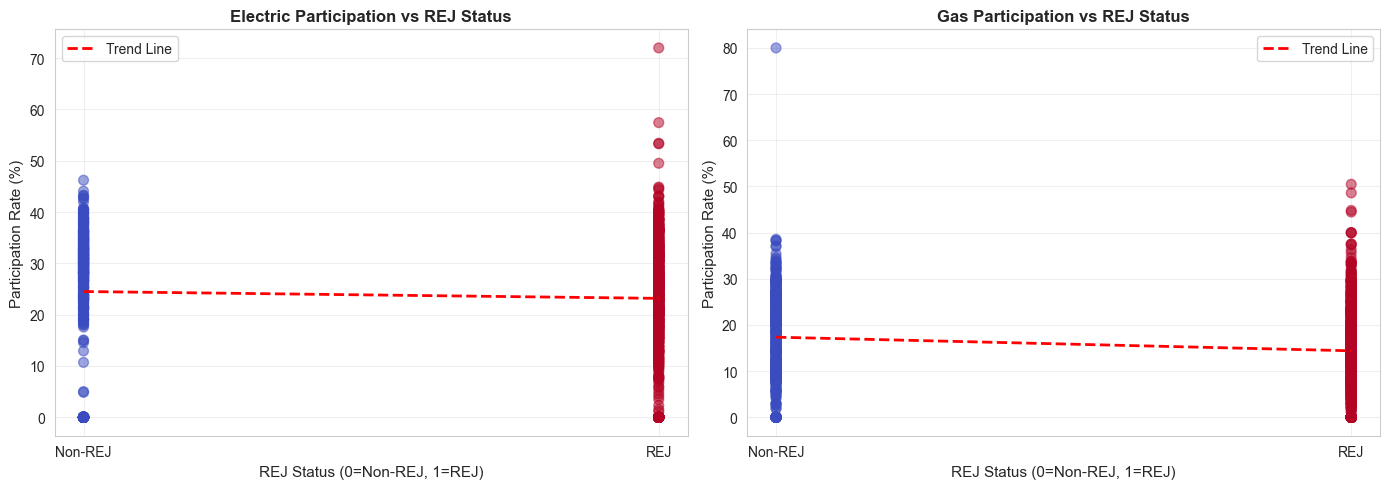

✓ Scatter plots saved to ../visualizations/participation_scatter_plots.png


In [14]:
### 9.3 Scatter Plots with Trend Lines
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Electric participation scatter plot
axes[0].scatter(plot_data['REJ_flag_numeric'], plot_data['electric_participation_rate_avg'],
                alpha=0.5, s=50, c=plot_data['REJ_flag_numeric'], cmap='coolwarm')
# Add regression line
z = np.polyfit(plot_data['REJ_flag_numeric'], plot_data['electric_participation_rate_avg'], 1)
p = np.poly1d(z)
x_line = np.linspace(plot_data['REJ_flag_numeric'].min(), plot_data['REJ_flag_numeric'].max(), 100)
axes[0].plot(x_line, p(x_line), "r--", linewidth=2, label='Trend Line')
axes[0].set_title('Electric Participation vs REJ Status', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Participation Rate (%)', fontsize=11)
axes[0].set_xlabel('REJ Status (0=Non-REJ, 1=REJ)', fontsize=11)
axes[0].set_xticks([0, 1])
axes[0].set_xticklabels(['Non-REJ', 'REJ'])
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Gas participation scatter plot
axes[1].scatter(plot_data['REJ_flag_numeric'], plot_data['gas_participation_rate_avg'],
                alpha=0.5, s=50, c=plot_data['REJ_flag_numeric'], cmap='coolwarm')
# Add regression line
z_gas = np.polyfit(plot_data['REJ_flag_numeric'], plot_data['gas_participation_rate_avg'], 1)
p_gas = np.poly1d(z_gas)
axes[1].plot(x_line, p_gas(x_line), "r--", linewidth=2, label='Trend Line')
axes[1].set_title('Gas Participation vs REJ Status', fontsize=12, fontweight='bold')
axes[1].set_ylabel('Participation Rate (%)', fontsize=11)
axes[1].set_xlabel('REJ Status (0=Non-REJ, 1=REJ)', fontsize=11)
axes[1].set_xticks([0, 1])
axes[1].set_xticklabels(['Non-REJ', 'REJ'])
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('../visualizations/participation_scatter_plots.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Scatter plots saved to ../visualizations/participation_scatter_plots.png")

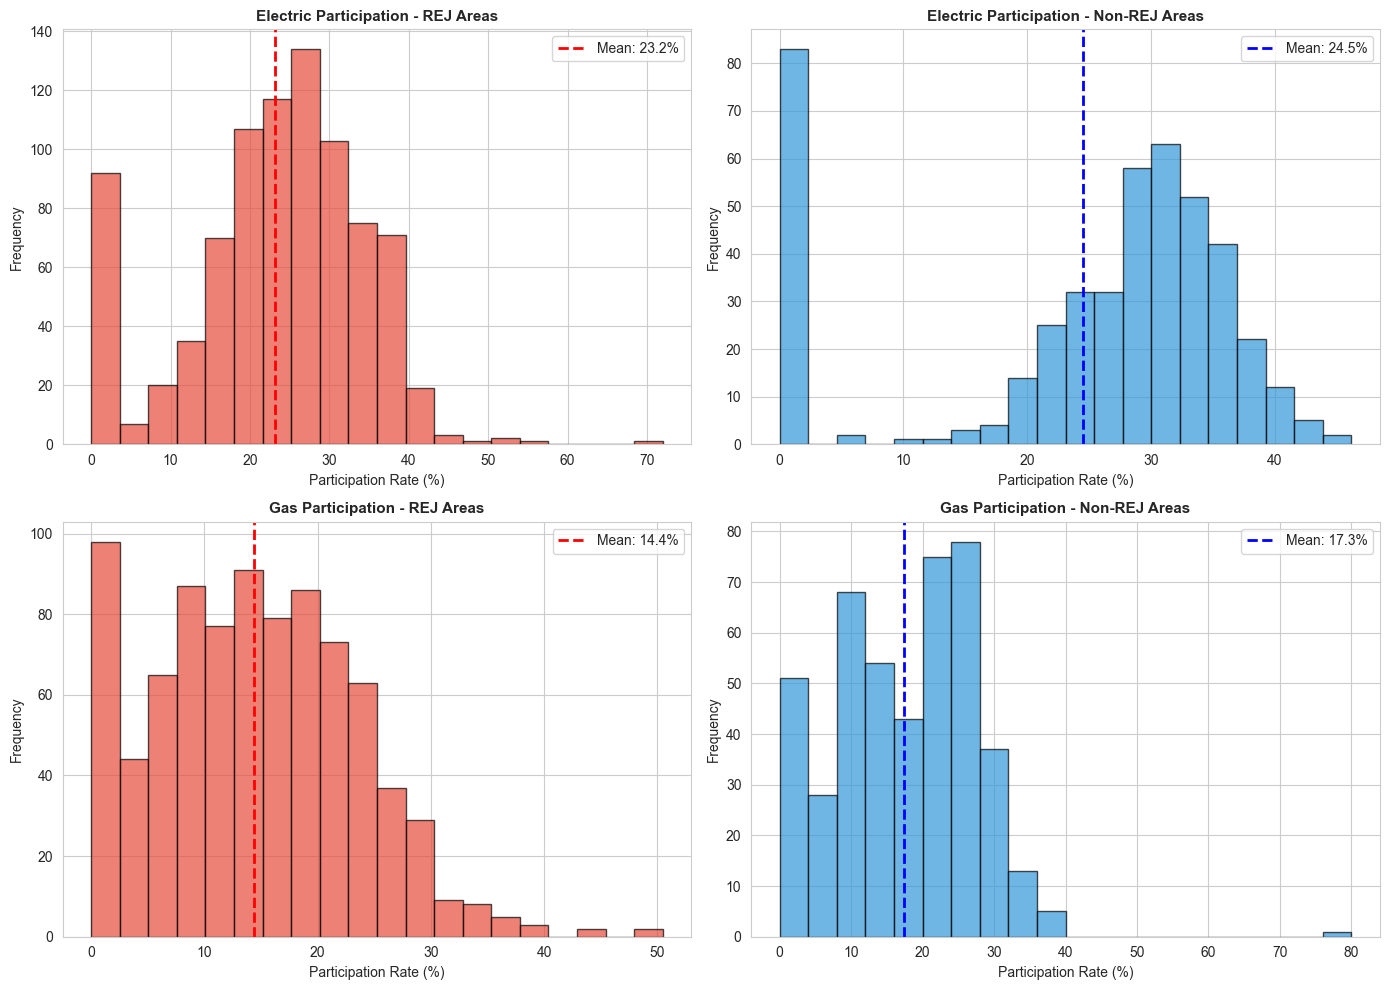

✓ Distribution plots saved to ../visualizations/participation_distributions.png


In [15]:
### 9.4 Distribution Plots (Histograms)
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Electric - REJ
axes[0, 0].hist(rej_group['electric_participation_rate_avg'].dropna(), bins=20, 
                color='#e74c3c', alpha=0.7, edgecolor='black')
axes[0, 0].set_title('Electric Participation - REJ Areas', fontsize=11, fontweight='bold')
axes[0, 0].set_xlabel('Participation Rate (%)')
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].axvline(rej_group['electric_participation_rate_avg'].mean(), color='red', 
                   linestyle='--', linewidth=2, label=f"Mean: {rej_group['electric_participation_rate_avg'].mean():.1f}%")
axes[0, 0].legend()

# Electric - Non-REJ
axes[0, 1].hist(non_rej_group['electric_participation_rate_avg'].dropna(), bins=20,
                color='#3498db', alpha=0.7, edgecolor='black')
axes[0, 1].set_title('Electric Participation - Non-REJ Areas', fontsize=11, fontweight='bold')
axes[0, 1].set_xlabel('Participation Rate (%)')
axes[0, 1].set_ylabel('Frequency')
axes[0, 1].axvline(non_rej_group['electric_participation_rate_avg'].mean(), color='blue',
                   linestyle='--', linewidth=2, label=f"Mean: {non_rej_group['electric_participation_rate_avg'].mean():.1f}%")
axes[0, 1].legend()

# Gas - REJ
axes[1, 0].hist(rej_group['gas_participation_rate_avg'].dropna(), bins=20,
                color='#e74c3c', alpha=0.7, edgecolor='black')
axes[1, 0].set_title('Gas Participation - REJ Areas', fontsize=11, fontweight='bold')
axes[1, 0].set_xlabel('Participation Rate (%)')
axes[1, 0].set_ylabel('Frequency')
axes[1, 0].axvline(rej_group['gas_participation_rate_avg'].mean(), color='red',
                   linestyle='--', linewidth=2, label=f"Mean: {rej_group['gas_participation_rate_avg'].mean():.1f}%")
axes[1, 0].legend()

# Gas - Non-REJ
axes[1, 1].hist(non_rej_group['gas_participation_rate_avg'].dropna(), bins=20,
                color='#3498db', alpha=0.7, edgecolor='black')
axes[1, 1].set_title('Gas Participation - Non-REJ Areas', fontsize=11, fontweight='bold')
axes[1, 1].set_xlabel('Participation Rate (%)')
axes[1, 1].set_ylabel('Frequency')
axes[1, 1].axvline(non_rej_group['gas_participation_rate_avg'].mean(), color='blue',
                   linestyle='--', linewidth=2, label=f"Mean: {non_rej_group['gas_participation_rate_avg'].mean():.1f}%")
axes[1, 1].legend()

plt.tight_layout()
plt.savefig('../visualizations/participation_distributions.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Distribution plots saved to ../visualizations/participation_distributions.png")

## Section 10: Analysis of Demographic Subgroups

Examine participation rates across demographic flags (Zero Vehicle Households, Seniors, Disability) 
to understand disparities within REJ areas.

In [16]:
# Demographic flags analysis
print("="*80)
print("MEAN PARTICIPATION RATES BY DEMOGRAPHIC CHARACTERISTICS")
print("="*80)

demographic_flags = [
    ('ZVHH_flag', 'Zero Vehicle Households (ZVHH)'),
    ('Senior_fla', 'High Senior Rate'),
    ('Disabili_f', 'High Disability Rate')
]

for flag_col, flag_name in demographic_flags:
    print(f"\n{flag_name.upper()}")
    print("-" * 80)
    
    # Overall for this demographic
    flag_data = data_clean[data_clean[flag_col] == 1.0]
    if len(flag_data) > 0:
        print(f"Tracts with flag: {len(flag_data)}")
        print(f"  Electric Mean: {flag_data['electric_participation_rate_avg'].mean():.2f}%")
        print(f"  Gas Mean:      {flag_data['gas_participation_rate_avg'].mean():.2f}%")
        
        # Within this demographic, compare REJ vs non-REJ
        flag_rej = flag_data[flag_data['REJ_flag_numeric'] == 1.0]
        flag_non_rej = flag_data[flag_data['REJ_flag_numeric'] == 0.0]
        
        if len(flag_rej) > 0 and len(flag_non_rej) > 0:
            print(f"\n  Within this demographic:")
            print(f"    REJ areas ({len(flag_rej)} tracts):")
            print(f"      Electric: {flag_rej['electric_participation_rate_avg'].mean():.2f}%")
            print(f"      Gas:      {flag_rej['gas_participation_rate_avg'].mean():.2f}%")
            print(f"    Non-REJ areas ({len(flag_non_rej)} tracts):")
            print(f"      Electric: {flag_non_rej['electric_participation_rate_avg'].mean():.2f}%")
            print(f"      Gas:      {flag_non_rej['gas_participation_rate_avg'].mean():.2f}%")

MEAN PARTICIPATION RATES BY DEMOGRAPHIC CHARACTERISTICS

ZERO VEHICLE HOUSEHOLDS (ZVHH)
--------------------------------------------------------------------------------
Tracts with flag: 330
  Electric Mean: 21.24%
  Gas Mean:      11.20%

HIGH SENIOR RATE
--------------------------------------------------------------------------------
Tracts with flag: 328
  Electric Mean: 24.35%
  Gas Mean:      16.82%

HIGH DISABILITY RATE
--------------------------------------------------------------------------------
Tracts with flag: 324
  Electric Mean: 23.15%
  Gas Mean:      13.48%


## Section 11: Summary of Key Findings

Synthesize all the statistical analysis into actionable insights for the blog post/article.

In [17]:
# Create a comprehensive summary
print("\n\n" + "="*80)
print("EXECUTIVE SUMMARY: HYPOTHESIS TESTING RESULTS")
print("="*80)

print("\nRESEARCH QUESTION:")
print("Do Regional Environmental Justice (REJ) areas have significantly lower")
print("participation rates in MassSave energy efficiency programs?")

print("\n" + "-"*80)
print("KEY FINDINGS:")
print("-"*80)

print(f"\n1. ELECTRIC PARTICIPATION RATE")
print(f"   REJ Mean:        {rej_group['electric_participation_rate_avg'].mean():.2f}%")
print(f"   Non-REJ Mean:    {non_rej_group['electric_participation_rate_avg'].mean():.2f}%")
print(f"   Difference:      {rej_group['electric_participation_rate_avg'].mean() - non_rej_group['electric_participation_rate_avg'].mean():.2f} percentage points")
print(f"   t-test p-value:  {p_value_elec:.6f}", 
      "→ SIGNIFICANT" if p_value_elec < 0.05 else "→ NOT SIGNIFICANT")
print(f"   Mann-Whitney p-value: {p_value_mw_elec:.6f}",
      "→ SIGNIFICANT" if p_value_mw_elec < 0.05 else "→ NOT SIGNIFICANT")

print(f"\n2. GAS PARTICIPATION RATE")
print(f"   REJ Mean:        {rej_group['gas_participation_rate_avg'].mean():.2f}%")
print(f"   Non-REJ Mean:    {non_rej_group['gas_participation_rate_avg'].mean():.2f}%")
print(f"   Difference:      {rej_group['gas_participation_rate_avg'].mean() - non_rej_group['gas_participation_rate_avg'].mean():.2f} percentage points")
print(f"   t-test p-value:  {p_value_gas:.6f}",
      "→ SIGNIFICANT" if p_value_gas < 0.05 else "→ NOT SIGNIFICANT")
print(f"   Mann-Whitney p-value: {p_value_mw_gas:.6f}",
      "→ SIGNIFICANT" if p_value_mw_gas < 0.05 else "→ NOT SIGNIFICANT")

print(f"\n3. CORRELATION ANALYSIS")
print(f"   Electric (Pearson):  r = {pearson_r_elec:.4f}, p = {p_pear_elec:.6f}")
print(f"   Gas (Pearson):       r = {pearson_r_gas:.4f}, p = {p_pear_gas:.6f}")
print(f"   Electric (Spearman): ρ = {spearman_r_elec:.4f}, p = {p_spear_elec:.6f}")
print(f"   Gas (Spearman):      ρ = {spearman_r_gas:.4f}, p = {p_spear_gas:.6f}")

print(f"\n4. EFFECT SIZE (Cohen's d)")
print(f"   Electric: {d_elec:.4f}", "Small" if abs(d_elec) < 0.5 else "Medium" if abs(d_elec) < 0.8 else "Large")
print(f"   Gas:      {d_gas:.4f}", "Small" if abs(d_gas) < 0.5 else "Medium" if abs(d_gas) < 0.8 else "Large")

print(f"\n5. SAMPLE SIZES")
print(f"   REJ tracts:         {len(rej_group)}")
print(f"   Non-REJ tracts:     {len(non_rej_group)}")
print(f"   Total tracts:       {len(data_clean)}")

print("\n" + "-"*80)
print("INTERPRETATION FOR BLOG POST:")
print("-"*80)

# Determine hypothesis support
elec_sig = p_value_elec < 0.05
gas_sig = p_value_gas < 0.05

if elec_sig or gas_sig:
    print("\n✓ HYPOTHESIS SUPPORTED - Statistically significant disparities found")
    if elec_sig:
        direction_elec = "LOWER" if rej_group['electric_participation_rate_avg'].mean() < non_rej_group['electric_participation_rate_avg'].mean() else "HIGHER"
        print(f"  • Electric: REJ areas have {direction_elec} participation rates (p={p_value_elec:.4f})")
    if gas_sig:
        direction_gas = "LOWER" if rej_group['gas_participation_rate_avg'].mean() < non_rej_group['gas_participation_rate_avg'].mean() else "HIGHER"
        print(f"  • Gas: REJ areas have {direction_gas} participation rates (p={p_value_gas:.4f})")
else:
    print("\n✗ HYPOTHESIS NOT SUPPORTED - No statistically significant disparities detected")
    print(f"  • Electric difference: {abs(rej_group['electric_participation_rate_avg'].mean() - non_rej_group['electric_participation_rate_avg'].mean()):.2f}pp (p={p_value_elec:.4f})")
    print(f"  • Gas difference:      {abs(rej_group['gas_participation_rate_avg'].mean() - non_rej_group['gas_participation_rate_avg'].mean()):.2f}pp (p={p_value_gas:.4f})")

print("\n" + "="*80)



EXECUTIVE SUMMARY: HYPOTHESIS TESTING RESULTS

RESEARCH QUESTION:
Do Regional Environmental Justice (REJ) areas have significantly lower
participation rates in MassSave energy efficiency programs?

--------------------------------------------------------------------------------
KEY FINDINGS:
--------------------------------------------------------------------------------

1. ELECTRIC PARTICIPATION RATE
   REJ Mean:        23.18%
   Non-REJ Mean:    24.51%
   Difference:      -1.33 percentage points
   t-test p-value:  0.052873 → NOT SIGNIFICANT
   Mann-Whitney p-value: 0.000005 → SIGNIFICANT

2. GAS PARTICIPATION RATE
   REJ Mean:        14.40%
   Non-REJ Mean:    17.35%
   Difference:      -2.95 percentage points
   t-test p-value:  0.000000 → SIGNIFICANT
   Mann-Whitney p-value: 0.000000 → SIGNIFICANT

3. CORRELATION ANALYSIS
   Electric (Pearson):  r = -0.0535, p = 0.052873
   Gas (Pearson):       r = -0.1481, p = 0.000000
   Electric (Spearman): ρ = -0.1266, p = 0.000004
   Gas (

## Section 12: Recommendations for Blog Post/Article

Based on the statistical findings above, consider these elements for your write-up:

### Key Talking Points:
1. **Lead with the Data**: Start with clear statistics on participation rate differences
2. **Contextualize Significance**: Explain what p-values and statistical significance mean for non-technical readers
3. **Use Visualizations**: Reference the generated charts to support narrative points
4. **Acknowledge Limitations**: Note sample sizes, geographic coverage, and data collection methods
5. **Call to Action**: Suggest policy interventions or further investigation

### Article Structure Suggestions:
- **Headline**: Focus on the disparity (if significant) or lack thereof
- **Lede**: Open with the most striking finding and why it matters
- **Methods**: Brief explanation of how you analyzed the data (avoid jargon)
- **Findings**: Present results with visuals
- **Analysis**: Discuss potential causes and implications
- **Recommendations**: Suggest next steps for policymakers or utilities
- **Conclusion**: Reinforce key message

### For Policymakers:
- Quantify the gap and its implications for environmental justice
- Suggest targeted outreach programs in underserved REJ areas
- Recommend barriers research to understand low participation
- Propose incentive structures that encourage REJ participation

### Questions for Further Investigation:
- What barriers prevent participation in REJ areas? (Cost, awareness, language, accessibility)
- Are REJ areas receiving equitable marketing/outreach?
- What is the demographic profile of participants vs. non-participants?
- How do participation patterns vary by utility and program type?